<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/mlflow/summarization/Convert_T5_large_to_ONNX_mlflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T5 finetuning for text Summarization

- Extractive: extract the most relevant information from a document.
- Abstractive: generate new text that captures the most relevant information.

https://arxiv.org/pdf/1910.10683

https://huggingface.co/docs/transformers/model_doc/t5


- T5 is an encoder-decoder model pre-trained on a multi-task mixture of unsupervised and supervised tasks and for which each task is converted into a text-to-text format. T5 works well on a variety of tasks out-of-the-box by prepending a different prefix to the input corresponding to each task, e.g., for translation: translate English to German: …, for summarization: summarize: ….

- The pretraining includes both supervised and self-supervised training. Supervised training is conducted on downstream tasks provided by the GLUE and SuperGLUE benchmarks (converting them into text-to-text tasks as explained above).

- Self-supervised training uses corrupted tokens, by randomly removing 15% of the tokens and replacing them with individual sentinel tokens (if several consecutive tokens are marked for removal, the whole group is replaced with a single sentinel token). The input of the encoder is the corrupted sentence, the input of the decoder is the original sentence and the target is then the dropped out tokens delimited by their sentinel tokens.

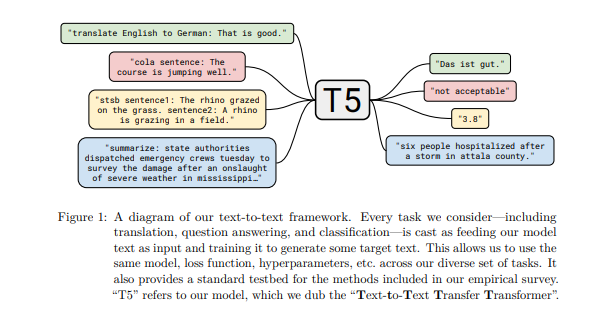

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install mlflow   optimum --quiet
! pip install  evaluate  textstat tiktoken -q
! pip install psutil pynvml -q

In [ ]:
# Transformers installation
! pip install -q --disable-pip-version-check py7zr sentencepiece loralib peft trl
! pip install -q   bitsandbytes
! pip install datasets evaluate rouge_score -q
! pip install transformers[torch] -q
! pip install accelerate -U -q
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

# Optimum
Optimum is an extension of Transformers that provides a set of performance optimization tools to train and run models on targeted hardware with maximum efficiency.

- https://huggingface.co/docs/optimum/main/en/installation
- https://huggingface.co/docs/optimum/onnxruntime/usage_guides/models

#ONNX
ONNX Runtime is a cross-platform machine-learning model accelerator, with a flexible interface to integrate hardware-specific libraries. ONNX Runtime can be used with models from PyTorch, Tensorflow/Keras, TFLite, scikit-learn, and other frameworks.

https://onnxruntime.ai/docs/

In [ ]:
! pip install onnxruntime -q
! pip install optimum[onnxruntime] -q

In [ ]:
from google.colab import userdata



In [ ]:

import argparse
import bitsandbytes as bnb
from datasets import load_dataset
from functools import partial
import os
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, AutoPeftModelForCausalLM
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed, Trainer, TrainingArguments, BitsAndBytesConfig, \
    DataCollatorForLanguageModeling, Trainer, TrainingArguments
from datasets import load_dataset
from torch import cuda, bfloat16
import transformers
import openai
import torch
import torch.nn as nn
from google.colab import userdata

In [ ]:

from google.colab import output
output.enable_custom_widget_manager()

from transformers.utils import logging


In [ ]:
logging.set_verbosity_error()

os.environ["TRANSFORMERS_VERBOSITY"] = "error"

In [ ]:


device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'
device


# Load multi_news dataset
https://huggingface.co/datasets/multi_news

In [ ]:
from datasets import load_dataset

dataset  = load_dataset("multi_news", trust_remote_code=True)

In [ ]:
dataset

In [ ]:

print(f"Train dataset size: {len(dataset['train'])}")
print(f"test dataset size: {len(dataset['test'])}")
print(f"Validation dataset size: {len(dataset['validation'])}")

In [ ]:
dataset['train'][100]['document']

In [ ]:

len(dataset['train'][100]['document'])

In [ ]:

len(dataset['train'][100]['summary'])

In [ ]:
import transformers
from mlflow.models import infer_signature
from mlflow.transformers import generate_signature_output
import locale
import mlflow
import json
import datetime
import pandas as pd
import numpy as np
import os
import pprint
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
model_uri = "runs:/a3cb2376e04b48c8b654ac42401dd387/text_summarizer"

In [ ]:
MLFLOW_TRACKING_URI="databricks"
# Specify the workspace hostname and token
DATABRICKS_HOST="https://adb-2467347032368999.19.azuredatabricks.net/"
DATABRICKS_TOKEN=userdata.get('DATABRCKS_TTOKEN')

In [ ]:


if "MLFLOW_TRACKING_URI" not in os.environ:
    os.environ["MLFLOW_TRACKING_URI"] = MLFLOW_TRACKING_URI
if "DATABRICKS_HOST" not in os.environ:
    os.environ["DATABRICKS_HOST"] = DATABRICKS_HOST
if "DATABRICKS_TOKEN" not in os.environ:
    os.environ["DATABRICKS_TOKEN"] = DATABRICKS_TOKEN

In [ ]:
os.environ["OPENAI_API_KEY"]=userdata.get('KEY_OPENAI')

In [ ]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [ ]:

mlflow.set_experiment("/Users/pepe@kk.com/summarization_fine_tuning")


In [ ]:
mlflow.end_run()

In [ ]:
summarization_components = mlflow.transformers.load_model(
    model_uri, return_type="components"
)

In [ ]:
summarization_components.keys()

In [ ]:
summarization_components['model'].save_pretrained("/content/drive/MyDrive/MODELS/t5-finetuned")

In [ ]:
summarization_components['task'], summarization_components['framework'], summarization_components['torch_dtype']

In [ ]:

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [ ]:
model_id = "/content/drive/MyDrive/MODELS/t5-finetuned"
model = summarization_components['model']
tokenizer = summarization_components['tokenizer']


In [ ]:
from optimum.onnxruntime import ORTModelForSeq2SeqLM
from optimum.onnxruntime import ORTQuantizer
from optimum.pipelines import pipeline
import mlflow
from mlflow.models.signature import infer_signature
from mlflow.pyfunc import PythonModel
import pprint

# Install Optimum
- https://huggingface.co/docs/optimum/main/en/exporters/onnx/usage_guides/export_a_model

- https://huggingface.co/docs/optimum/exporters/onnx/usage_guides/export_a_model

- https://huggingface.co/docs/optimum/main/en/installation

```
python -m pip install optimum

pip install --upgrade --upgrade-strategy eager optimum[onnxruntime]
```


```
optimum-cli export onnx --model ./t5-finetuned --for-ort --task seq2seq-lm-with-past t5_onnx/
```

```
optimum-cli export onnx --help

usage: optimum-cli <command> [<args>] export onnx [-h] -m MODEL [--task TASK] [--monolith] [--device DEVICE] [--opset OPSET] [--atol ATOL]
                                                  [--framework {pt,tf}] [--pad_token_id PAD_TOKEN_ID] [--cache_dir CACHE_DIR] [--trust-remote-code]
                                                  [--no-post-process] [--optimize {O1,O2,O3,O4}] [--batch_size BATCH_SIZE]
                                                  [--sequence_length SEQUENCE_LENGTH] [--num_choices NUM_CHOICES] [--width WIDTH] [--height HEIGHT]
                                                  [--num_channels NUM_CHANNELS] [--feature_size FEATURE_SIZE] [--nb_max_frames NB_MAX_FRAMES]
                                                  [--audio_sequence_length AUDIO_SEQUENCE_LENGTH]
                                                  output

optional arguments:
  -h, --help            show this help message and exit

Required arguments:
  -m MODEL, --model MODEL
                        Model ID on huggingface.co or path on disk to load model from.
  output                Path indicating the directory where to store generated ONNX model.

Optional arguments:
  --task TASK           The task to export the model for. If not specified, the task will be auto-inferred based on the model. Available tasks depend on the model, but are among: ['default', 'fill-mask', 'text-generation', 'text2text-generation', 'text-classification', 'token-classification', 'multiple-choice', 'object-detection', 'question-answering', 'image-classification', 'image-segmentation', 'masked-im', 'semantic-segmentation', 'automatic-speech-recognition', 'audio-classification', 'audio-frame-classification', 'automatic-speech-recognition', 'audio-xvector', 'image-to-text', 'zero-shot-object-detection', 'image-to-image', 'inpainting', 'text-to-image']. For decoder models, use `xxx-with-past` to export the model using past key values in the decoder.
  --monolith            Force to export the model as a single ONNX file. By default, the ONNX exporter may break the model in several ONNX files, for example for encoder-decoder models where the encoder should be run only once while the decoder is looped over.
  --device DEVICE       The device to use to do the export. Defaults to "cpu".
  --opset OPSET         If specified, ONNX opset version to export the model with. Otherwise, the default opset will be used.
  --atol ATOL           If specified, the absolute difference tolerance when validating the model. Otherwise, the default atol for the model will be used.
  --framework {pt,tf}   The framework to use for the ONNX export. If not provided, will attempt to use the local checkpoint's original framework or what is available in the environment.
  --pad_token_id PAD_TOKEN_ID
                        This is needed by some models, for some tasks. If not provided, will attempt to use the tokenizer to guess it.
  --cache_dir CACHE_DIR
                        Path indicating where to store cache.
  --trust-remote-code   Allows to use custom code for the modeling hosted in the model repository. This option should only be set for repositories you trust and in which you have read the code, as it will execute on your local machine arbitrary code present in the model repository.
  --no-post-process     Allows to disable any post-processing done by default on the exported ONNX models. For example, the merging of decoder and decoder-with-past models into a single ONNX model file to reduce memory usage.
  --optimize {O1,O2,O3,O4}
                        Allows to run ONNX Runtime optimizations directly during the export. Some of these optimizations are specific to ONNX Runtime, and the resulting ONNX will not be usable with other runtime as OpenVINO or TensorRT. Possible options:
                            - O1: Basic general optimizations
                            - O2: Basic and extended general optimizations, transformers-specific fusions
                            - O3: Same as O2 with GELU approximation
                            - O4: Same as O3 with mixed precision (fp16, GPU-only, requires `--device cuda`)
```

In [ ]:
model = ORTModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/MODELS/t5_onnx")

In [ ]:
tokenizer.save_pretrained("/content/drive/MyDrive/MODELS/t5_onnx")

In [ ]:
pipe = pipeline(summarization_components['task'], model=model, tokenizer=tokenizer)
result = pipe(dataset['validation'][100]['document'])

In [ ]:
# pprint.pprint(dataset['validation'][100]['document'])

In [ ]:
pprint.pprint(result[0]['summary_text'])



In [ ]:
MODEL_NAME = "google-t5/t5-large"

In [ ]:
class ONNXModelForSeq2SeqLM(PythonModel):
  def load_context(self, context):
        """
        This method initializes the tokenizer and language model
        using the specified model snapshot directory.
        """

        from transformers import AutoTokenizer
        from optimum.onnxruntime import ORTModelForSeq2SeqLM
        from optimum.pipelines import pipeline

        self.model = ORTModelForSeq2SeqLM.from_pretrained(context.artifacts["snapshot"])
        self.tokenizer = AutoTokenizer.from_pretrained(context.artifacts["snapshot"])


  def predict(self, context, model_input, params=None):
        """
        This method generates prediction for the given input.
        """
        prompt = model_input["prompt"][0]
         # Retrieve or use default values for temperature and max_tokens
        temperature = params.get("temperature", 0.7) if params else 0.7
        max_tokens = params.get("max_tokens", 128) if params else 128
        task = params.get("task", "summarization") if params else "summarization"


        pipe = pipeline(task, model=self.model, tokenizer=self.tokenizer)
        result = pipe(prompt)
        return {"candidates": [result[0]['summary_text']]}


In [ ]:
import numpy as np
import pandas as pd

import mlflow
from mlflow.models.signature import ModelSignature
from mlflow.types import ColSpec, DataType, ParamSchema, ParamSpec, Schema

# Define input and output schema
input_schema = Schema(
    [
        ColSpec(DataType.string, "prompt"),
    ]
)
output_schema = Schema([ColSpec(DataType.string, "candidates")])

parameters = ParamSchema(
    [
        ParamSpec("temperature", DataType.float, np.float32(0.1), None),
        ParamSpec("max_tokens", DataType.integer, np.int32(1000), None),
        ParamSpec("task", DataType.string, "summarization"),
    ]
)

signature = ModelSignature(inputs=input_schema, outputs=output_schema,  params=parameters)


# Define input example
input_example = pd.DataFrame({"prompt": [dataset['validation'][100]['document']]})

In [ ]:
mlflow.set_experiment("/Users/pepe@kk.com/log_summariaztion_onnx")

In [ ]:
import datetime
now = datetime.datetime.now()
now.strftime("%Y-%m-%d_%H:%M:%S")

In [ ]:
# Get the current base version of torch that is installed, without specific version modifiers
torch_version = torch.__version__.split("+")[0]

In [ ]:

# Start an MLflow run context and log the PHi3 model wrapper along with the param-included signature to
# allow for overriding parameters at inference time
now = datetime.datetime.now()

description= """Fine Tuned T5-Large Model converted to ONNX with optimum-cli
command :
optimum-cli export onnx --model ./t5-finetuned --for-ort --task seq2seq-lm-with-past t5_onnx/
"""
with mlflow.start_run(run_name=f"convert_to_onnx_{now.strftime('%Y-%m-%d_%H:%M:%S')}", description=description) as run:
    model_info = mlflow.pyfunc.log_model(
        "t5-summarization-onnx",
        python_model=ONNXModelForSeq2SeqLM(),
        # NOTE: the artifacts dictionary mapping is critical! This dict is used by the load_context() method in our PHi3() class.
        artifacts={"snapshot": "/content/drive/MyDrive/MODELS/t5_onnx"},

        pip_requirements=[
            f"torch=={torch_version}",
            f"transformers=={transformers.__version__}",
             "onnxruntime",
             "optimum[onnxruntime]",
            "optimum",

        ],
        input_example=input_example,
        signature=signature,
    )

In [ ]:
run.to_dictionary()

In [ ]:

model_info.model_uri

In [ ]:
loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)

In [ ]:
loaded_model

In [ ]:
test1= dataset['test'][100]['document']

In [ ]:

time1=  datetime.datetime.now()
response = loaded_model.predict(pd.DataFrame(
    {"prompt": [test1]}), params={"temperature": 0.8, "max_tokens": 128}
)
time2=  datetime.datetime.now()
print(time2-time1)

In [ ]:

pprint.pprint(response['candidates'][0])

# Optimum Optimize 2
optimum-cli export onnx --model ./t5-finetuned --for-ort --optimize O2 --task seq2seq-lm-with-past t5_onnx_2/


In [ ]:
model2 = ORTModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/MODELS/t5_onnx_2")

In [ ]:
tokenizer.save_pretrained("/content/drive/MyDrive/MODELS/t5_onnx_2")

In [ ]:
pipe2 = pipeline(summarization_components['task'], model=model2, tokenizer=tokenizer)
result2 = pipe2(dataset['validation'][100]['document'])

In [ ]:
pprint.pprint(result2[0]['summary_text'])

In [ ]:
# Start an MLflow run context and log the PHi3 model wrapper along with the param-included signature to
# allow for overriding parameters at inference time
now = datetime.datetime.now()

description= """Fine Tuned T5-Large Model converted to ONNX with optimum-cli . Optimization type O2
command :
optimum-cli export onnx --model ./t5-finetuned --for-ort --optimize O2 --task seq2seq-lm-with-past t5_onnx_2/
"""
with mlflow.start_run(run_name=f"convert_to_onnx_{now.strftime('%Y-%m-%d_%H:%M:%S')}", description=description) as run:
    model_info = mlflow.pyfunc.log_model(
        "t5-summarization-onnx",
        python_model=ONNXModelForSeq2SeqLM(),
        # NOTE: the artifacts dictionary mapping is critical! This dict is used by the load_context() method in our PHi3() class.
        artifacts={"snapshot": "/content/drive/MyDrive/MODELS/t5_onnx_2"},

        pip_requirements=[
            f"torch=={torch_version}",
            f"transformers=={transformers.__version__}",
             "onnxruntime",
             "optimum[onnxruntime]",

        ],
        input_example=input_example,
        signature=signature,
    )

In [ ]:
del pipe
del model
del model2
del pipe2


import gc
import torch
torch.cuda.empty_cache()
gc.collect()

In [ ]:
run.to_dictionary()

In [ ]:
model_info.model_uri # runs:/b11f3045f8984a75a6bd4f84b16a2373/t5-summarization-onnx

In [ ]:
model_uri = "runs:/b11f3045f8984a75a6bd4f84b16a2373/t5-summarization-onnx"

In [ ]:
loaded_model = mlflow.pyfunc.load_model("runs:/ae87afe853fd45c484645fce2bc6125e/t5-summarization-onnx")

In [ ]:
test1= dataset['test'][100]['document']

In [ ]:
time1=  datetime.datetime.now()
response = loaded_model.predict(pd.DataFrame(
    {"prompt": [test1]}), params={"temperature": 0.8, "max_tokens": 128}
)
time2=  datetime.datetime.now()
print(time2-time1)


In [ ]:
pprint.pprint(response['candidates'][0])

# Quantization

https://huggingface.co/docs/optimum/main/en/onnxruntime/package_reference/quantization#optimum.onnxruntime.ORTQuantizer


In [ ]:
from functools import partial
from transformers import AutoTokenizer
from optimum.onnxruntime import ORTQuantizer, ORTModelForSeq2SeqLM
from optimum.onnxruntime.configuration import AutoQuantizationConfig, AutoCalibrationConfig



In [ ]:
onnx_model  = ORTModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/MODELS/t5_onnx")
model_dir = onnx_model.model_save_dir

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/MODELS/t5_onnx")

In [ ]:
encoder_quantizer = ORTQuantizer.from_pretrained(model_dir, file_name="encoder_model.onnx")

decoder_quantizer = ORTQuantizer.from_pretrained(model_dir, file_name="decoder_model.onnx")

decoder_wp_quantizer = ORTQuantizer.from_pretrained(model_dir, file_name="decoder_with_past_model.onnx")

decoder_merged_quantizer = ORTQuantizer.from_pretrained(model_dir, file_name="decoder_model_merged.onnx")

quantizer = [encoder_quantizer, decoder_quantizer, decoder_wp_quantizer, decoder_merged_quantizer]

In [ ]:
q_folder = "/content/drive/MyDrive/MODELS/t5_onnx_quantized"

In [ ]:
dqconfig = AutoQuantizationConfig.avx512_vnni(is_static=False, per_channel=False)

for q in quantizer:
    q.quantize(save_dir=q_folder,quantization_config=dqconfig)  # doctest: +IGNORE_RESULT



In [ ]:
dqconfig

# save tokenizer

In [ ]:
tokenizer.save_pretrained(q_folder)

In [ ]:
del onnx_model

del encoder_quantizer
del decoder_quantizer
del decoder_wp_quantizer
del quantizer
del dqconfig

In [ ]:
model2 = ORTModelForSeq2SeqLM.from_pretrained(q_folder)

In [ ]:
pipe3 = pipeline("summarization", model=model2, tokenizer=tokenizer)
result3 = pipe3(dataset['validation'][100]['document'])

In [ ]:
pprint.pprint(result3[0]['summary_text'])

In [ ]:
del model2
del pipe3

In [ ]:
# Start an MLflow run context and log the PHi3 model wrapper along with the param-included signature to
# allow for overriding parameters at inference time
now = datetime.datetime.now()

description= """Fine Tuned T5-Large Model converted to ONNX with optimum-cli and quantized INT8
command :
```
onnx_model  = ORTModelForSeq2SeqLM.from_pretrained("/content/drive/MyDrive/MODELS/t5_onnx")
model_dir = onnx_model.model_save_dir
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/MODELS/t5_onnx")

encoder_quantizer = ORTQuantizer.from_pretrained(model_dir, file_name="encoder_model.onnx")

decoder_quantizer = ORTQuantizer.from_pretrained(model_dir, file_name="decoder_model.onnx")

decoder_wp_quantizer = ORTQuantizer.from_pretrained(model_dir, file_name="decoder_with_past_model.onnx")

decoder_merged_quantizer = ORTQuantizer.from_pretrained(model_dir, file_name="decoder_model_merged.onnx")

quantizer = [encoder_quantizer, decoder_quantizer, decoder_wp_quantizer, decoder_merged_quantizer]

q_folder = "/content/drive/MyDrive/MODELS/t5_onnx_quantized"

dqconfig = AutoQuantizationConfig.avx512_vnni(is_static=False, per_channel=False)

for q in quantizer:
    q.quantize(save_dir=q_folder,quantization_config=dqconfig)
```

"""
with mlflow.start_run(run_name=f"convert_to_onnx_{now.strftime('%Y-%m-%d_%H:%M:%S')}", description=description) as run:
    model_info = mlflow.pyfunc.log_model(
        "t5-summarization-onnx",
        python_model=ONNXModelForSeq2SeqLM(),

        artifacts={"snapshot": q_folder},

        pip_requirements=[
            f"torch=={torch_version}",
            f"transformers=={transformers.__version__}",
             "onnxruntime",
             "optimum[onnxruntime]",

        ],
        input_example=input_example,
        signature=signature,
    )

In [ ]:
run.to_dictionary()

In [ ]:
model_info.model_uri

In [ ]:
loaded_model = mlflow.pyfunc.load_model("runs:/d642ef3d86f9489983e3b088f9cded6d/t5-summarization-onnx")

In [ ]:
test1= dataset['test'][100]['document']

In [ ]:
time1=  datetime.datetime.now()
response = loaded_model.predict(pd.DataFrame(
    {"prompt": [test1]})
)
time2=  datetime.datetime.now()
print(time2-time1)

In [ ]:
pprint.pprint(response)

# TODO in EVALUATION MODEL

In [ ]:
from typing import List
def onnx_summ(inputs: pd.DataFrame) -> List[str]:
    predictions = []

    loaded_model = mlflow.pyfunc.load_model(model_uri)
    for _, row in inputs.iterrows():
        response = loaded_model.predict(pd.DataFrame(
    {"prompt": [row["inputs"]]})
)
        predictions.append(response['candidates'][0])

    return predictions

In [ ]:
df_test = dataset['validation'].to_pandas()

In [ ]:
df_test.columns = ['inputs', 'summary']

In [ ]:
df_test.head()

In [ ]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

In [ ]:
# now = datetime.datetime.now()

# description= """Evaluation  Tuned T5-Large Model converted to ONNX with optimum-cli and quantized INT8

# """
# with mlflow.start_run(run_name=f"evaluation_to_onnx_{now.strftime('%Y-%m-%d_%H:%M:%S')}", description=description) as run:

#     results = mlflow.evaluate(
#          model=onnx_summ,
#          data= df_test[:10],
#         targets="summary",  # specify which column corresponds to the expected output
#         model_type="text-summarization",  # model type indicates which metrics are relevant for this task
#         evaluators="default",
#     )
# results.metrics

In [ ]:
#pprint.pprint(results.metrics)